# CIC-IIoT-2025 Cybersecurity Analysis

## Network Traffic Classification and Anomaly Detection for Industrial IoT Security

**Authors:** Alexis Le Trung, Yahya Ahachim, Rayan Drissi, Aniss Outaleb

---

### Project Overview
This notebook presents a comprehensive analysis of the CIC-IIoT-2025 dataset for cybersecurity purposes, including:
1. **Data Exploration and Characterization**
2. **Anomaly Detection** using 3 complementary unsupervised algorithms
3. **Classification** using 3 complementary supervised algorithms
4. **Performance Evaluation** with industry-standard metrics
5. **Adversarial ML Attacks** (Bonus)

### Dataset
The CIC-IIoT-2025 dataset contains network traffic data from Industrial IoT environments, with both benign and various attack samples captured at different time intervals (1-10 seconds).

## Table of Contents

1. [Setup and Imports](#1-setup-and-imports)
2. [Data Loading](#2-data-loading)
3. [Data Exploration](#3-data-exploration)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Anomaly Detection](#5-anomaly-detection)
   - 5.1 Isolation Forest
   - 5.2 One-Class SVM
   - 5.3 Local Outlier Factor (LOF)
6. [Classification](#6-classification)
   - 6.1 Random Forest
   - 6.2 Gradient Boosting (XGBoost)
   - 6.3 Support Vector Machine (SVM)
7. [Model Comparison](#7-model-comparison)
8. [Adversarial Attacks (Bonus)](#8-adversarial-attacks)
9. [Conclusions](#9-conclusions)

---
## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# Scikit-learn - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

# Scikit-learn - Classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Scikit-learn - Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Scikit-learn - Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc
)

# For AUPRC calculation
from sklearn.metrics import PrecisionRecallDisplay

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All imports successful!
NumPy version: 2.2.6
Pandas version: 2.3.3


---
## 2. Data Loading

In [2]:
# Define paths
ATTACK_PATH = 'data/attack_data/'
BENIGN_PATH = 'data/benign_data/'

# We'll use the 1-second sample data for comprehensive analysis
# This provides the most granular view of network behavior
TIME_INTERVAL = '1sec'

print("Loading attack data...")
df_attack = pd.read_csv(f'{ATTACK_PATH}attack_samples_{TIME_INTERVAL}.csv')
print(f"Attack samples loaded: {len(df_attack):,} rows")

print("\nLoading benign data...")
df_benign = pd.read_csv(f'{BENIGN_PATH}benign_samples_{TIME_INTERVAL}.csv')
print(f"Benign samples loaded: {len(df_benign):,} rows")

# Check column consistency
print(f"\nAttack columns: {len(df_attack.columns)}")
print(f"Benign columns: {len(df_benign.columns)}")

# Add binary label column
df_attack['is_attack'] = 1
df_benign['is_attack'] = 0

# Combine datasets
df = pd.concat([df_attack, df_benign], ignore_index=True)
print(f"\nTotal combined samples: {len(df):,} rows")
print(f"Attack ratio: {df['is_attack'].mean():.2%}")

Loading attack data...
Attack samples loaded: 90,391 rows

Loading benign data...
Benign samples loaded: 136,800 rows

Attack columns: 94
Benign columns: 94

Total combined samples: 227,191 rows
Attack ratio: 39.79%


---
## 3. Data Exploration

In [3]:
# Basic dataset info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal Samples: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print(f"\nClass Distribution:")
print(df['is_attack'].value_counts())
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1e6:.2f} MB")

DATASET OVERVIEW

Total Samples: 227,191
Total Features: 95

Class Distribution:
is_attack
0    136800
1     90391
Name: count, dtype: int64

Memory Usage: 1200.28 MB


In [4]:
# Examine columns and their types
print("\n" + "=" * 60)
print("COLUMN ANALYSIS")
print("=" * 60)

# Identify column types
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  - {col}: {df[col].nunique()} unique values")

print(f"\nNumerical columns: {len(numerical_cols)}")


COLUMN ANALYSIS

Categorical columns (23):
  - device_name: 38 unique values
  - device_mac: 38 unique values
  - label_full: 937 unique values
  - label1: 2 unique values
  - label2: 8 unique values
  - label3: 61 unique values
  - label4: 84 unique values
  - timestamp: 92136 unique values
  - timestamp_start: 92136 unique values
  - timestamp_end: 92136 unique values
  - log_data-types: 7 unique values
  - network_ips_all: 20004 unique values
  - network_ips_dst: 19141 unique values
  - network_ips_src: 19119 unique values
  - network_macs_all: 19416 unique values
  - network_macs_dst: 18124 unique values
  - network_macs_src: 17291 unique values
  - network_ports_all: 64550 unique values
  - network_ports_dst: 57883 unique values
  - network_ports_src: 64015 unique values
  - network_protocols_all: 2423 unique values
  - network_protocols_dst: 1670 unique values
  - network_protocols_src: 913 unique values

Numerical columns: 72


In [5]:
# Analyze attack types
print("\n" + "=" * 60)
print("ATTACK TYPE ANALYSIS")
print("=" * 60)

# Attack categories (label2)
print("\nAttack Categories (label2):")
attack_categories = df[df['is_attack'] == 1]['label2'].value_counts()
print(attack_categories)

# Specific attack types (label3)
print("\nSpecific Attack Types (label3):")
attack_types = df[df['is_attack'] == 1]['label3'].value_counts()
print(attack_types)


ATTACK TYPE ANALYSIS

Attack Categories (label2):
label2
recon         33648
dos           18420
ddos          18056
mitm           8062
malware        7541
web            2796
bruteforce     1868
Name: count, dtype: int64

Specific Attack Types (label3):
label3
arp-spoofing                    4196
mirai-udp-flood                 4010
os-scan                         3968
host-disc-tcp-ack-ping          3947
vuln-scan                       3944
host-disc-tcp-syn-ping          3932
port-scan                       3924
host-disc-tcp-syn-stealth       3918
host-disc-arp-ping              3911
host-disc-udp-ping              3894
mirai-syn-flood                 3531
icmp-flood                      3314
udp-frag-flood                  3189
icmp-frag-flood                 3189
ip-spoofing                     3040
rst-fin-flood-port-1883         2214
ping-sweep                      2210
ack-frag-flood-port-1883        1846
synonymousip-flood-port-1883    1846
push-ack-flood-port-1883        1

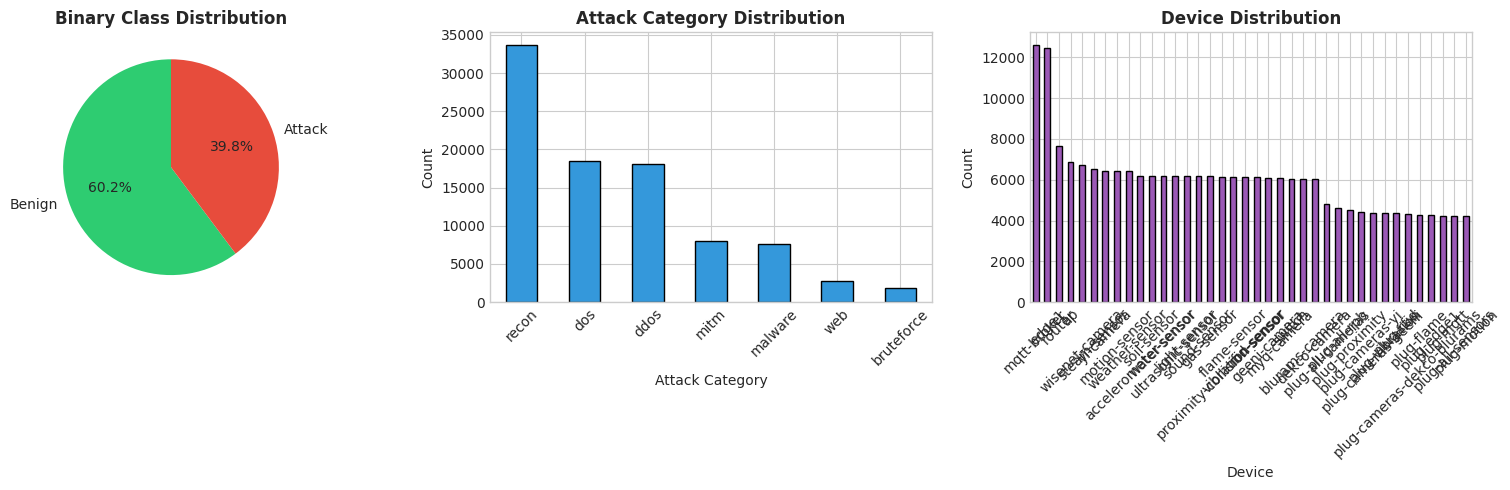

In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Binary classification distribution
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
labels = ['Benign', 'Attack']
sizes = df['is_attack'].value_counts().values
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Binary Class Distribution', fontsize=12, fontweight='bold')

# Attack category distribution
ax2 = axes[1]
attack_cats = df[df['is_attack'] == 1]['label2'].value_counts()
attack_cats.plot(kind='bar', ax=ax2, color='#3498db', edgecolor='black')
ax2.set_title('Attack Category Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Attack Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Device distribution
ax3 = axes[2]
device_counts = df['device_name'].value_counts()
device_counts.plot(kind='bar', ax=ax3, color='#9b59b6', edgecolor='black')
ax3.set_title('Device Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Device')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Statistical summary of numerical features
print("\n" + "=" * 60)
print("NUMERICAL FEATURES STATISTICS")
print("=" * 60)

# Select key network features for analysis
key_features = [
    'network_packets_all_count',
    'network_packet-size_avg',
    'network_tcp-flags-syn_count',
    'network_tcp-flags-ack_count',
    'network_time-delta_avg',
    'network_ip-length_avg',
    'network_ttl_avg'
]

# Check which features exist
available_features = [f for f in key_features if f in df.columns]
print(f"\nAnalyzing {len(available_features)} key network features:")
print(df[available_features].describe().T)


NUMERICAL FEATURES STATISTICS

Analyzing 7 key network features:
                                count         mean           std       min  \
network_packets_all_count    227191.0  7175.175997  24065.343671  0.000000   
network_packet-size_avg      227191.0   104.364973    207.403272  0.000000   
network_tcp-flags-syn_count  227191.0  1034.243020   8324.997778  0.000000   
network_tcp-flags-ack_count  227191.0  1200.282445   8564.992198  0.000000   
network_time-delta_avg       227191.0     0.006911      0.016569 -0.000001   
network_ip-length_avg        227191.0    91.342058    209.445283  0.000000   
network_ttl_avg              227191.0    72.026003     75.240130  0.000000   

                             25%        50%         75%            max  
network_packets_all_count    0.0   2.000000   50.000000  149006.000000  
network_packet-size_avg      0.0  60.000000   70.041667    2229.947368  
network_tcp-flags-syn_count  0.0   0.000000    0.000000  122231.000000  
network_tcp-flags

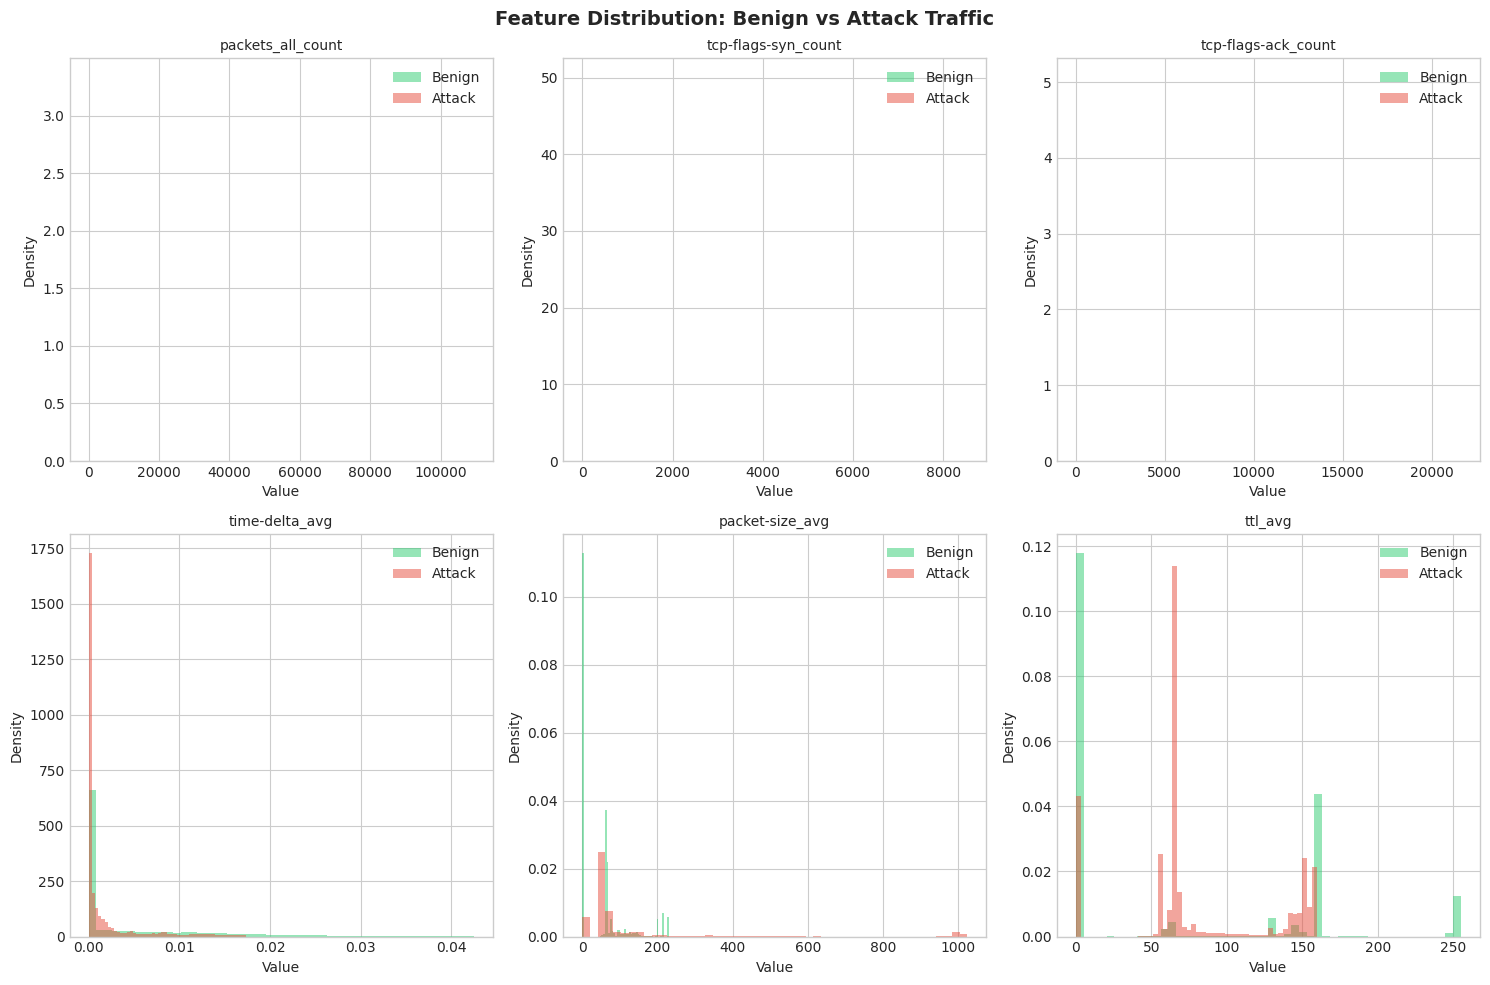

In [8]:
# Compare feature distributions between attack and benign traffic
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select features for comparison
compare_features = [
    'network_packets_all_count',
    'network_tcp-flags-syn_count',
    'network_tcp-flags-ack_count',
    'network_time-delta_avg',
    'network_packet-size_avg',
    'network_ttl_avg'
]

for idx, feature in enumerate(compare_features):
    if feature in df.columns:
        ax = axes[idx]
        
        # Get data for benign and attack
        benign_data = df[df['is_attack'] == 0][feature].dropna()
        attack_data = df[df['is_attack'] == 1][feature].dropna()
        
        # Remove outliers for better visualization (using IQR)
        def remove_outliers(data):
            Q1, Q3 = data.quantile(0.05), data.quantile(0.95)
            return data[(data >= Q1) & (data <= Q3)]
        
        benign_clean = remove_outliers(benign_data)
        attack_clean = remove_outliers(attack_data)
        
        # Plot histograms
        ax.hist(benign_clean, bins=50, alpha=0.5, label='Benign', color='#2ecc71', density=True)
        ax.hist(attack_clean, bins=50, alpha=0.5, label='Attack', color='#e74c3c', density=True)
        ax.set_title(feature.replace('network_', ''), fontsize=10)
        ax.legend()
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')

plt.suptitle('Feature Distribution: Benign vs Attack Traffic', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Correlation analysis of key features
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Select numerical features for correlation
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-informative columns
exclude_cols = ['is_attack']
num_features = [f for f in num_features if f not in exclude_cols]

# Compute correlation with target
correlations = df[num_features + ['is_attack']].corr()['is_attack'].drop('is_attack')
top_corr = correlations.abs().sort_values(ascending=False).head(20)

print("\nTop 20 features most correlated with attack/benign:")
for feat, corr_val in top_corr.items():
    actual_corr = correlations[feat]
    print(f"  {feat}: {actual_corr:.4f}")


CORRELATION ANALYSIS

Top 20 features most correlated with attack/benign:
  network_mss_max: 0.5256
  network_mss_avg: 0.5251
  network_mss_min: 0.5232
  network_header-length_min: 0.4635
  network_header-length_max: 0.4635
  network_header-length_avg: 0.4635
  network_protocols_dst_count: 0.4232
  network_protocols_all_count: 0.3793
  network_packets_all_count: 0.3666
  network_protocols_src_count: 0.3632
  network_macs_all_count: 0.3619
  network_packets_dst_count: 0.3544
  network_macs_src_count: 0.3537
  network_macs_dst_count: 0.3537
  network_ips_src_count: 0.3495
  network_ports_all_count: 0.3055
  network_ports_src_count: 0.2891
  network_ip-flags_max: 0.2840
  network_packet-size_avg: 0.2611
  network_ip-length_avg: 0.2467


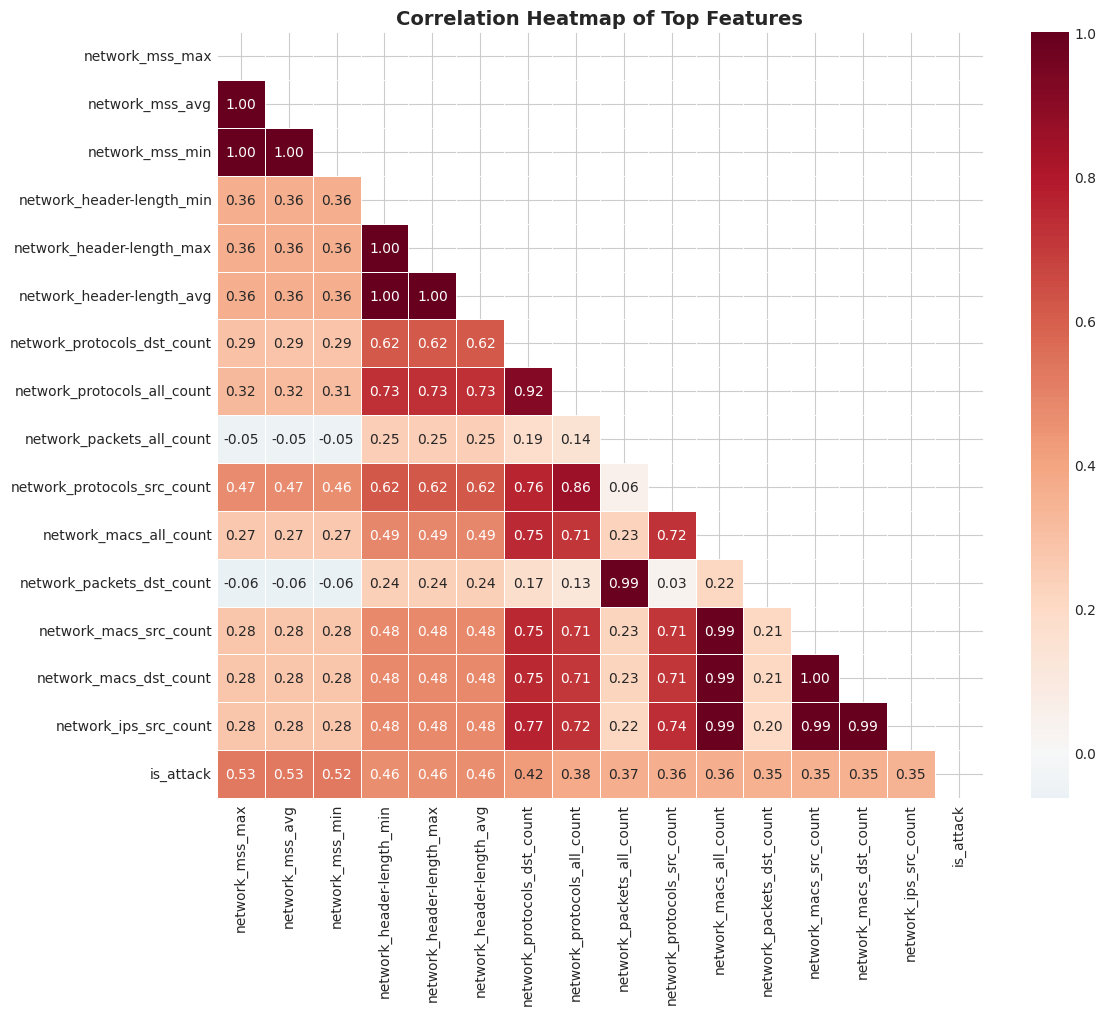

In [10]:
# Visualize correlation heatmap
# Select top correlated features
top_features = top_corr.index.tolist()[:15] + ['is_attack']
corr_matrix = df[top_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Top Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Data Preprocessing

In [11]:
# Identify feature columns (exclude metadata and labels)
metadata_cols = ['device_name', 'device_mac', 'label_full', 'label1', 'label2', 'label3', 'label4',
                 'timestamp', 'timestamp_start', 'timestamp_end', 'is_attack']

# Get feature columns (numerical only)
feature_cols = [col for col in df.columns if col not in metadata_cols]

# Remove columns that are lists/arrays stored as strings
def is_list_column(col):
    sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
    if isinstance(sample, str) and sample.startswith('['):
        return True
    return False

list_cols = [col for col in feature_cols if is_list_column(col)]
feature_cols = [col for col in feature_cols if col not in list_cols]

print(f"Number of features for modeling: {len(feature_cols)}")
print(f"Excluded list-type columns: {len(list_cols)}")

# Create feature matrix and target vector
X = df[feature_cols].copy()
y = df['is_attack'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Number of features for modeling: 71
Excluded list-type columns: 13

Feature matrix shape: (227191, 71)
Target vector shape: (227191,)


In [12]:
# Handle missing values
print("\n" + "=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

missing = X.isnull().sum()
missing_pct = (missing / len(X)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print(f"\nColumns with missing values: {len(missing_df)}")
    print(missing_df.head(10))
    
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found!")

# Verify no missing values remain
print(f"Remaining missing values: {X.isnull().sum().sum()}")


HANDLING MISSING VALUES
No missing values found!
Remaining missing values: 0


In [13]:
# Scale features
print("\n" + "=" * 60)
print("FEATURE SCALING")
print("=" * 60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Features scaled using StandardScaler")
print(f"Mean (should be ~0): {X_scaled.mean().mean():.6f}")
print(f"Std (should be ~1): {X_scaled.std().mean():.6f}")


FEATURE SCALING
Features scaled using StandardScaler
Mean (should be ~0): 0.000000
Std (should be ~1): 1.000002


In [14]:
# Split data into train and test sets
print("\n" + "=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X_scaled):.1%})")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X_scaled):.1%})")
print(f"\nTraining set attack ratio: {y_train.mean():.2%}")
print(f"Test set attack ratio: {y_test.mean():.2%}")


TRAIN/TEST SPLIT
Training set: 181,752 samples (80.0%)
Test set: 45,439 samples (20.0%)

Training set attack ratio: 39.79%
Test set attack ratio: 39.79%


In [15]:
# For efficiency, use a sample for complex models
# Full dataset is large, so we'll sample for initial modeling
print("\n" + "=" * 60)
print("CREATING BALANCED SAMPLE FOR EFFICIENT MODELING")
print("=" * 60)

SAMPLE_SIZE = 30000  # Use 30K samples for efficient training

# Stratified sample
if len(X_train) > SAMPLE_SIZE:
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train, train_size=SAMPLE_SIZE, random_state=RANDOM_STATE, stratify=y_train
    )
    print(f"Sampled {SAMPLE_SIZE:,} training examples for efficient modeling")
    print(f"Sample attack ratio: {y_train_sample.mean():.2%}")
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print("Using full training set")


CREATING BALANCED SAMPLE FOR EFFICIENT MODELING
Sampled 30,000 training examples for efficient modeling
Sample attack ratio: 39.79%


---
## 5. Anomaly Detection

For anomaly detection, we treat the problem as detecting attacks (anomalies) in a dataset of mostly normal (benign) traffic. We use three complementary unsupervised algorithms:

1. **Isolation Forest** - Tree-based isolation of anomalies
2. **One-Class SVM** - Kernel-based boundary learning
3. **Local Outlier Factor (LOF)** - Density-based anomaly detection

In [16]:
# Prepare data for anomaly detection
# Train on benign samples only, test on mixed data
print("=" * 60)
print("ANOMALY DETECTION - DATA PREPARATION")
print("=" * 60)

# For anomaly detection, we train primarily on benign data
X_benign = X_scaled[y == 0]
X_attack = X_scaled[y == 1]

# Sample benign data for training
BENIGN_TRAIN_SIZE = 20000
X_benign_train = X_benign.sample(n=min(BENIGN_TRAIN_SIZE, len(X_benign)), random_state=RANDOM_STATE)

# Create test set with both classes
TEST_SIZE = 10000
X_test_benign = X_benign.sample(n=min(TEST_SIZE//2, len(X_benign) - len(X_benign_train)), random_state=RANDOM_STATE+1)
X_test_attack = X_attack.sample(n=min(TEST_SIZE//2, len(X_attack)), random_state=RANDOM_STATE)

X_anomaly_test = pd.concat([X_test_benign, X_test_attack])
y_anomaly_test = np.array([0] * len(X_test_benign) + [1] * len(X_test_attack))

print(f"Training set (benign only): {len(X_benign_train):,} samples")
print(f"Test set: {len(X_anomaly_test):,} samples")
print(f"  - Benign: {len(X_test_benign):,}")
print(f"  - Attack: {len(X_test_attack):,}")

ANOMALY DETECTION - DATA PREPARATION
Training set (benign only): 20,000 samples
Test set: 10,000 samples
  - Benign: 5,000
  - Attack: 5,000


In [17]:
def evaluate_anomaly_detector(y_true, y_pred, model_name):
    """Evaluate anomaly detection model with comprehensive metrics."""
    # Convert predictions: -1 (anomaly) -> 1 (attack), 1 (normal) -> 0 (benign)
    y_pred_binary = (y_pred == -1).astype(int)
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Metrics
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    
    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': bal_acc,
        'mcc': mcc,
        'confusion_matrix': cm
    }

### 5.1 Isolation Forest

In [18]:
print("Training Isolation Forest...")

# Isolation Forest - contamination is the expected proportion of anomalies
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,  # Expect ~10% anomalies
    max_samples='auto',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit on benign data only
iso_forest.fit(X_benign_train)

# Predict on test set
y_pred_if = iso_forest.predict(X_anomaly_test)

# Evaluate
if_results = evaluate_anomaly_detector(y_anomaly_test, y_pred_if, "Isolation Forest")

Training Isolation Forest...

Isolation Forest Results

Confusion Matrix:
[[4486  514]
 [1121 3879]]

Precision: 0.8830
Recall: 0.7758
F1-Score: 0.8259
Balanced Accuracy: 0.8365
Matthews Correlation Coefficient (MCC): 0.6780


### 5.2 One-Class SVM

In [19]:
print("Training One-Class SVM...")

# Use a smaller sample for One-Class SVM (computationally expensive)
OCSVM_SAMPLE = 5000
X_ocsvm_train = X_benign_train.sample(n=min(OCSVM_SAMPLE, len(X_benign_train)), random_state=RANDOM_STATE)

ocsvm = OneClassSVM(
    kernel='rbf',
    nu=0.1,  # Upper bound on fraction of anomalies
    gamma='scale'
)

# Fit on benign data
ocsvm.fit(X_ocsvm_train)

# Predict on test set
y_pred_ocsvm = ocsvm.predict(X_anomaly_test)

# Evaluate
ocsvm_results = evaluate_anomaly_detector(y_anomaly_test, y_pred_ocsvm, "One-Class SVM")

Training One-Class SVM...

One-Class SVM Results

Confusion Matrix:
[[1990 3010]
 [ 762 4238]]

Precision: 0.5847
Recall: 0.8476
F1-Score: 0.6920
Balanced Accuracy: 0.6228
Matthews Correlation Coefficient (MCC): 0.2750


### 5.3 Local Outlier Factor (LOF)

In [20]:
print("Training Local Outlier Factor...")

# LOF with novelty detection
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.1,
    novelty=True,  # Enable predict on new data
    n_jobs=-1
)

# Fit on benign data
lof.fit(X_benign_train)

# Predict on test set
y_pred_lof = lof.predict(X_anomaly_test)

# Evaluate
lof_results = evaluate_anomaly_detector(y_anomaly_test, y_pred_lof, "Local Outlier Factor")

Training Local Outlier Factor...

Local Outlier Factor Results

Confusion Matrix:
[[4488  512]
 [ 983 4017]]

Precision: 0.8870
Recall: 0.8034
F1-Score: 0.8431
Balanced Accuracy: 0.8505
Matthews Correlation Coefficient (MCC): 0.7041



ANOMALY DETECTION COMPARISON


               model  precision  recall       f1  balanced_accuracy      mcc
    Isolation Forest   0.882996  0.7758 0.825934             0.8365 0.678015
       One-Class SVM   0.584713  0.8476 0.692031             0.6228 0.274957
Local Outlier Factor   0.886951  0.8034 0.843111             0.8505 0.704131


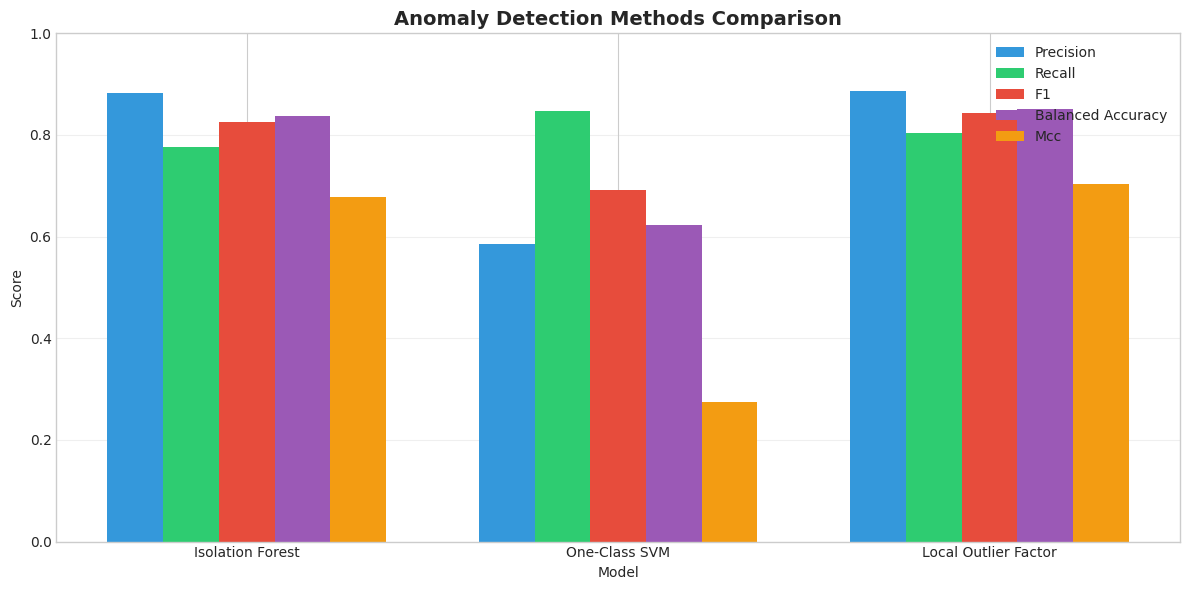

In [21]:
# Compare anomaly detection methods
print("\n" + "=" * 60)
print("ANOMALY DETECTION COMPARISON")
print("=" * 60)

anomaly_results = pd.DataFrame([
    {k: v for k, v in if_results.items() if k != 'confusion_matrix'},
    {k: v for k, v in ocsvm_results.items() if k != 'confusion_matrix'},
    {k: v for k, v in lof_results.items() if k != 'confusion_matrix'}
])

print("\n")
print(anomaly_results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(anomaly_results))
width = 0.15

metrics = ['precision', 'recall', 'f1', 'balanced_accuracy', 'mcc']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, anomaly_results[metric], width, label=metric.replace('_', ' ').title(), color=color)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Anomaly Detection Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(anomaly_results['model'])
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Classification

For supervised classification, we use three complementary algorithms:

1. **Random Forest** - Ensemble of decision trees
2. **Gradient Boosting** - Sequential tree boosting
3. **Support Vector Machine (SVM)** - Kernel-based classification

In [22]:
def evaluate_classifier(y_true, y_pred, y_proba, model_name):
    """Evaluate classifier with comprehensive metrics."""
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Attack']))
    
    # Key Metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # AUPRC (Area Under Precision-Recall Curve)
    auprc = average_precision_score(y_true, y_proba)
    
    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_proba)
    
    print(f"\nKey Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Balanced Accuracy: {bal_acc:.4f}")
    print(f"  Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"  AUPRC: {auprc:.4f}")
    print(f"  AUC-ROC: {auc_roc:.4f}")
    
    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': bal_acc,
        'mcc': mcc,
        'auprc': auprc,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_proba': y_proba
    }

### 6.1 Random Forest

In [23]:
print("Training Random Forest Classifier...")

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train on sampled data
rf_clf.fit(X_train_sample, y_train_sample)

# Predict on test set
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
rf_results = evaluate_classifier(y_test, y_pred_rf, y_proba_rf, "Random Forest")

Training Random Forest Classifier...

Random Forest Results

Confusion Matrix:
[[27227   133]
 [ 2483 15596]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      1.00      0.95     27360
      Attack       0.99      0.86      0.92     18079

    accuracy                           0.94     45439
   macro avg       0.95      0.93      0.94     45439
weighted avg       0.95      0.94      0.94     45439


Key Metrics:
  Precision: 0.9915
  Recall: 0.8627
  F1-Score: 0.9226
  Balanced Accuracy: 0.9289
  Matthews Correlation Coefficient (MCC): 0.8825
  AUPRC: 0.9438
  AUC-ROC: 0.9582



Top 15 Most Important Features (Random Forest):
                          feature  importance
        network_packets_all_count    0.112168
          network_packet-size_min    0.109501
        network_packets_dst_count    0.096313
           network_time-delta_min    0.084956
          network_ports_all_count    0.069797
          network_ports_src_count    0.052130
        network_packets_src_count    0.041356
         network_interval-packets    0.039671
          network_ports_dst_count    0.034366
      network_tcp-flags-rst_count    0.031445
           network_time-delta_avg    0.020797
                  network_ttl_max    0.016542
          network_window-size_min    0.015862
network_window-size_std_deviation    0.015528
      network_tcp-flags-syn_count    0.015482


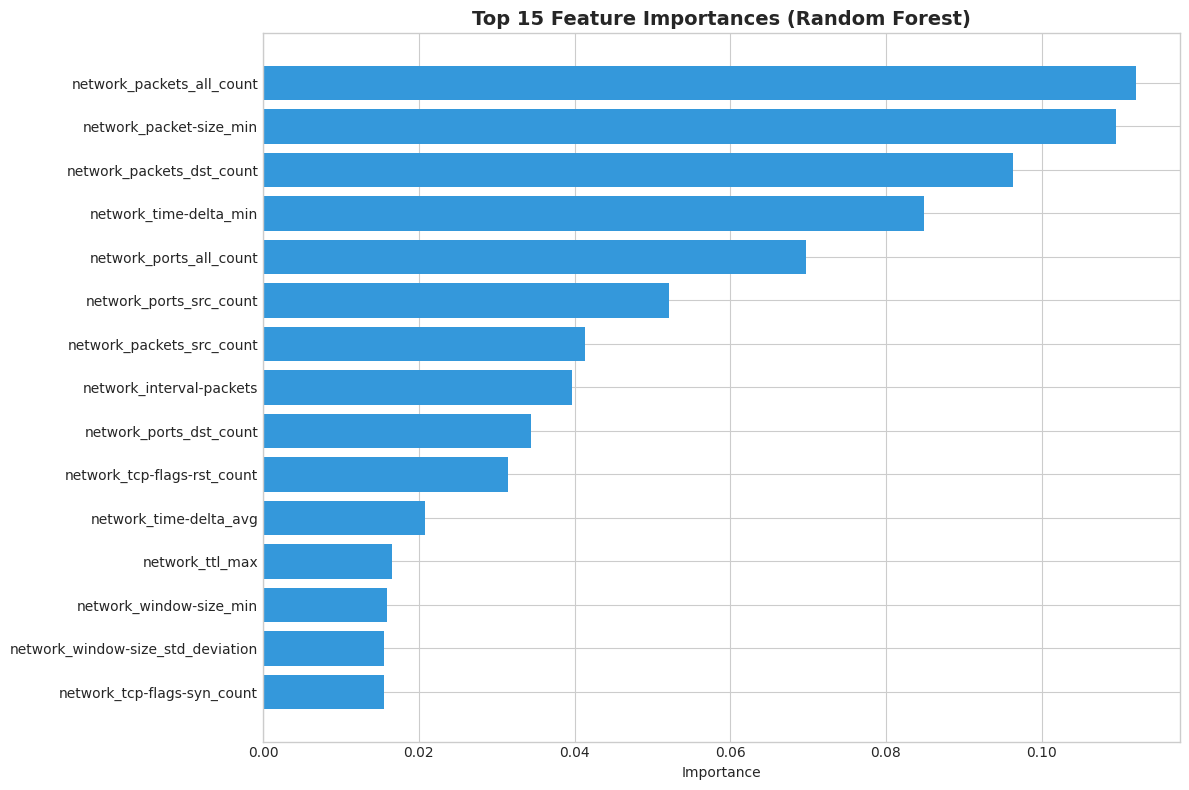

In [24]:
# Feature importance from Random Forest
print("\nTop 15 Most Important Features (Random Forest):")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance.head(15)
plt.barh(top_features_rf['feature'], top_features_rf['importance'], color='#3498db')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Gradient Boosting

In [25]:
print("Training Gradient Boosting Classifier...")

gb_clf = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

# Train on sampled data
gb_clf.fit(X_train_sample, y_train_sample)

# Predict on test set
y_pred_gb = gb_clf.predict(X_test)
y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Evaluate
gb_results = evaluate_classifier(y_test, y_pred_gb, y_proba_gb, "Gradient Boosting")

Training Gradient Boosting Classifier...

Gradient Boosting Results

Confusion Matrix:
[[27220   140]
 [ 2417 15662]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.99      0.96     27360
      Attack       0.99      0.87      0.92     18079

    accuracy                           0.94     45439
   macro avg       0.95      0.93      0.94     45439
weighted avg       0.95      0.94      0.94     45439


Key Metrics:
  Precision: 0.9911
  Recall: 0.8663
  F1-Score: 0.9245
  Balanced Accuracy: 0.9306
  Matthews Correlation Coefficient (MCC): 0.8851
  AUPRC: 0.9436
  AUC-ROC: 0.9587


### 6.3 Support Vector Machine (SVM)

In [26]:
print("Training SVM Classifier...")

# Use smaller sample for SVM (computationally expensive)
SVM_SAMPLE = 10000
X_svm_train = X_train_sample.sample(n=min(SVM_SAMPLE, len(X_train_sample)), random_state=RANDOM_STATE)
y_svm_train = y_train_sample.loc[X_svm_train.index]

svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Enable probability estimates
    random_state=RANDOM_STATE
)

# Train
svm_clf.fit(X_svm_train, y_svm_train)

# Predict on test set (sample for efficiency)
TEST_SAMPLE = 10000
X_test_sample = X_test.sample(n=min(TEST_SAMPLE, len(X_test)), random_state=RANDOM_STATE)
y_test_sample = y_test.loc[X_test_sample.index]

y_pred_svm = svm_clf.predict(X_test_sample)
y_proba_svm = svm_clf.predict_proba(X_test_sample)[:, 1]

# Evaluate
svm_results = evaluate_classifier(y_test_sample, y_pred_svm, y_proba_svm, "SVM (RBF Kernel)")

Training SVM Classifier...

SVM (RBF Kernel) Results

Confusion Matrix:
[[5841  124]
 [ 819 3216]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.98      0.93      5965
      Attack       0.96      0.80      0.87      4035

    accuracy                           0.91     10000
   macro avg       0.92      0.89      0.90     10000
weighted avg       0.91      0.91      0.90     10000


Key Metrics:
  Precision: 0.9629
  Recall: 0.7970
  F1-Score: 0.8721
  Balanced Accuracy: 0.8881
  Matthews Correlation Coefficient (MCC): 0.8074
  AUPRC: 0.9238
  AUC-ROC: 0.9325


---
## 7. Model Comparison

In [27]:
# Compile classification results
print("\n" + "=" * 60)
print("CLASSIFICATION MODELS COMPARISON")
print("=" * 60)

classification_results = pd.DataFrame([
    {k: v for k, v in rf_results.items() if k not in ['confusion_matrix', 'y_true', 'y_proba']},
    {k: v for k, v in gb_results.items() if k not in ['confusion_matrix', 'y_true', 'y_proba']},
    {k: v for k, v in svm_results.items() if k not in ['confusion_matrix', 'y_true', 'y_proba']}
])

print("\n")
print(classification_results.to_string(index=False))


CLASSIFICATION MODELS COMPARISON


            model  precision   recall       f1  balanced_accuracy      mcc    auprc  auc_roc
    Random Forest   0.991544 0.862658 0.922622           0.928899 0.882527 0.943833 0.958151
Gradient Boosting   0.991140 0.866309 0.924530           0.930596 0.885059 0.943612 0.958721
 SVM (RBF Kernel)   0.962874 0.797026 0.872136           0.888119 0.807442 0.923809 0.932499


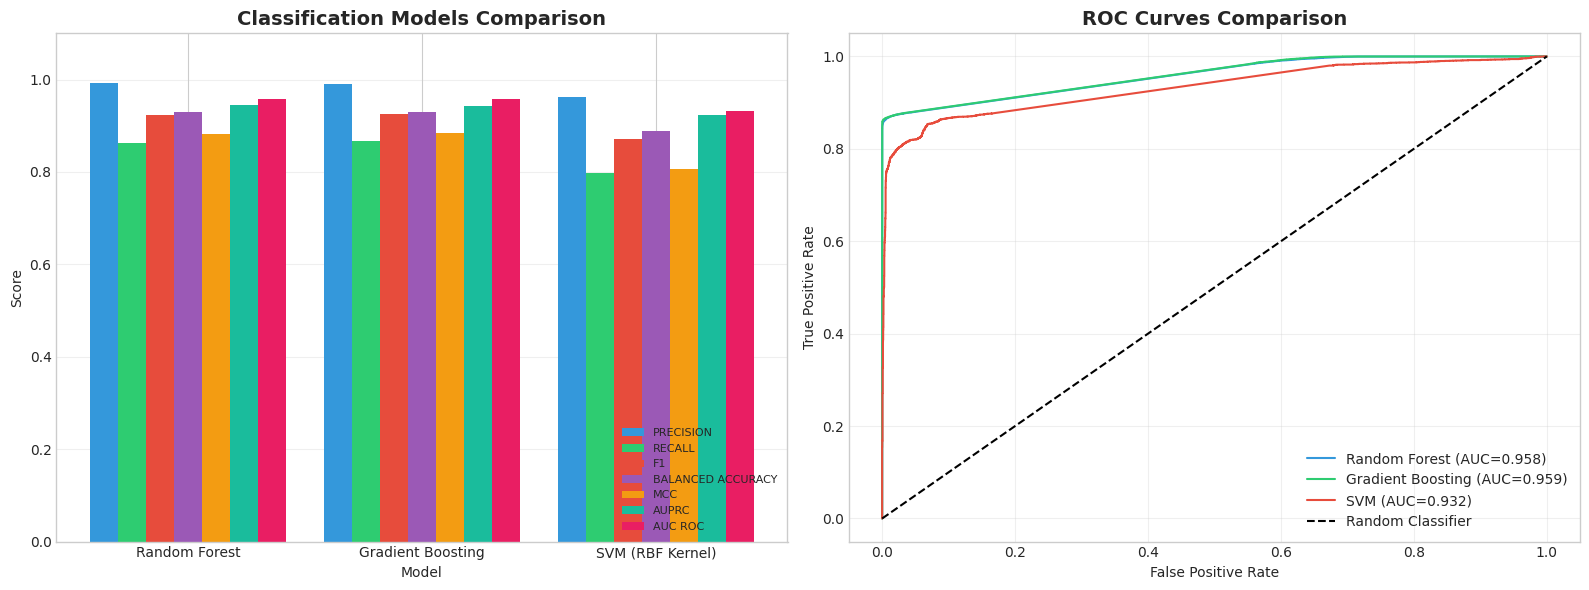

In [28]:
# Visualize classification comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax1 = axes[0]
x = np.arange(len(classification_results))
width = 0.12

metrics = ['precision', 'recall', 'f1', 'balanced_accuracy', 'mcc', 'auprc', 'auc_roc']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c', '#e91e63']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax1.bar(x + i*width, classification_results[metric], width, 
            label=metric.upper().replace('_', ' '), color=color)

ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('Classification Models Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 3)
ax1.set_xticklabels(classification_results['model'])
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# ROC Curves
ax2 = axes[1]
for result, color, name in [(rf_results, '#3498db', 'Random Forest'),
                            (gb_results, '#2ecc71', 'Gradient Boosting'),
                            (svm_results, '#e74c3c', 'SVM')]:
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_proba'])
    ax2.plot(fpr, tpr, color=color, label=f"{name} (AUC={result['auc_roc']:.3f})")

ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('classification_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

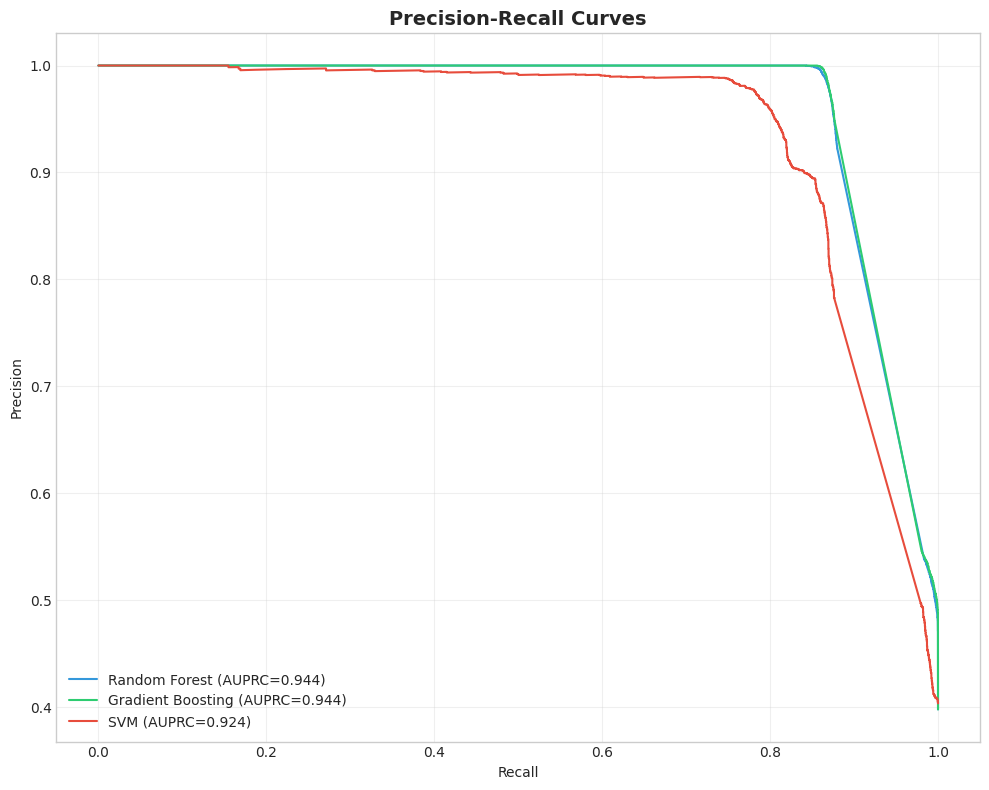

In [29]:
# Precision-Recall Curves
fig, ax = plt.subplots(figsize=(10, 8))

for result, color, name in [(rf_results, '#3498db', 'Random Forest'),
                            (gb_results, '#2ecc71', 'Gradient Boosting'),
                            (svm_results, '#e74c3c', 'SVM')]:
    precision_curve, recall_curve, _ = precision_recall_curve(result['y_true'], result['y_proba'])
    ax.plot(recall_curve, precision_curve, color=color, 
            label=f"{name} (AUPRC={result['auprc']:.3f})")

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()

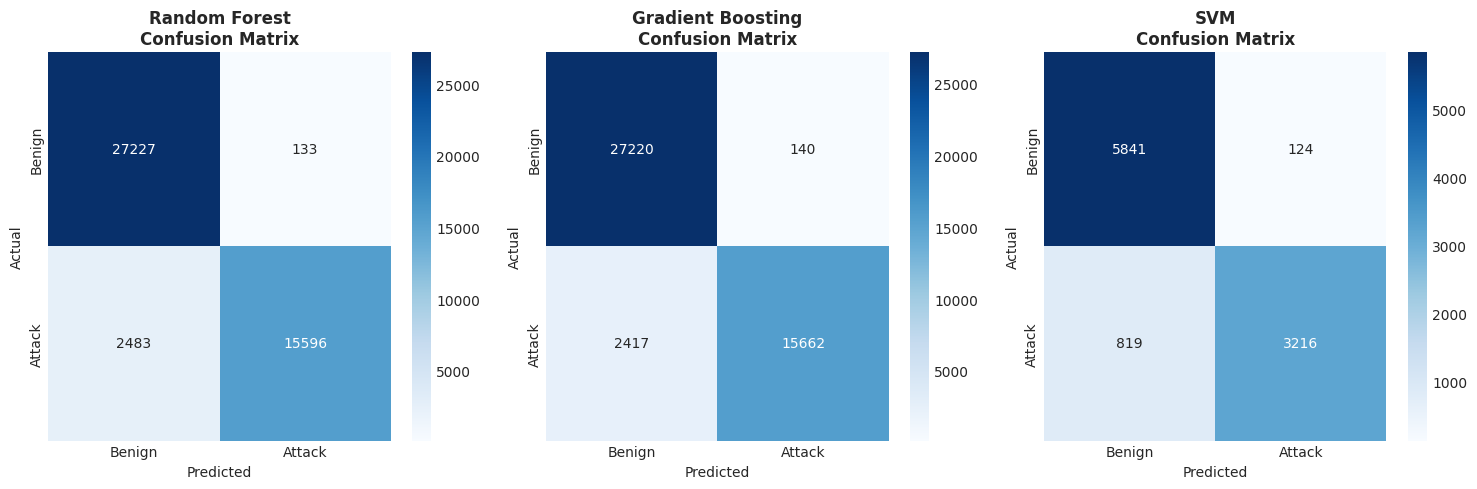

In [30]:
# Visualize Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, result, name in zip(axes, 
                            [rf_results, gb_results, svm_results],
                            ['Random Forest', 'Gradient Boosting', 'SVM']):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'])
    ax.set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Adversarial Attacks (Bonus)

We implement the Fast Gradient Sign Method (FGSM) to generate adversarial examples that can fool our trained classifiers.

In [31]:
# FGSM Attack Implementation for Linear SVM
print("=" * 60)
print("ADVERSARIAL ML - FGSM ATTACK")
print("=" * 60)

# Train a linear SVM for FGSM (works with linear models)
from sklearn.svm import LinearSVC

print("\nTraining Linear SVM for adversarial attack demonstration...")
linear_svm = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=10000,
    random_state=RANDOM_STATE
)

linear_svm.fit(X_svm_train, y_svm_train)
print(f"Linear SVM trained with {len(X_svm_train):,} samples")

# Get baseline accuracy
y_pred_baseline = linear_svm.predict(X_test_sample)
baseline_acc = (y_pred_baseline == y_test_sample).mean()
print(f"Baseline accuracy: {baseline_acc:.4f}")

ADVERSARIAL ML - FGSM ATTACK

Training Linear SVM for adversarial attack demonstration...
Linear SVM trained with 10,000 samples
Baseline accuracy: 0.8982


In [32]:
def fgsm_attack(X, y, model, epsilon):
    """
    Fast Gradient Sign Method attack for linear models.
    
    Args:
        X: Input features
        y: True labels
        model: Trained linear model with coef_ attribute
        epsilon: Perturbation magnitude
        
    Returns:
        X_adv: Adversarial examples
    """
    # For linear SVM, gradient direction is simply the weights
    weights = model.coef_[0]
    
    # FGSM: perturb in the direction of the gradient sign
    # For samples we want to misclassify as benign (0), move opposite to weights
    # For samples we want to misclassify as attack (1), move in direction of weights
    
    X_adv = X.copy()
    
    # For attack samples (y=1), we want them classified as benign
    # Move in direction opposite to weights * sign
    perturbation = epsilon * np.sign(weights)
    
    # Apply perturbation to flip predictions
    X_adv = X_adv - np.outer(y * 2 - 1, perturbation)  # Flip direction based on label
    
    return X_adv

# Test FGSM with different epsilon values
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
fgsm_results = []

print("\nFGSM Attack Results:")
print("-" * 50)

for eps in epsilons:
    X_adv = fgsm_attack(X_test_sample.values, y_test_sample.values, linear_svm, eps)
    y_pred_adv = linear_svm.predict(X_adv)
    adv_acc = (y_pred_adv == y_test_sample.values).mean()
    attack_success = 1 - adv_acc
    
    print(f"Epsilon: {eps:.2f} | Accuracy: {adv_acc:.4f} | Attack Success Rate: {attack_success:.4f}")
    
    fgsm_results.append({
        'epsilon': eps,
        'accuracy': adv_acc,
        'attack_success_rate': attack_success
    })

fgsm_df = pd.DataFrame(fgsm_results)


FGSM Attack Results:
--------------------------------------------------
Epsilon: 0.01 | Accuracy: 0.8672 | Attack Success Rate: 0.1328
Epsilon: 0.05 | Accuracy: 0.2596 | Attack Success Rate: 0.7404
Epsilon: 0.10 | Accuracy: 0.1595 | Attack Success Rate: 0.8405
Epsilon: 0.20 | Accuracy: 0.0929 | Attack Success Rate: 0.9071
Epsilon: 0.50 | Accuracy: 0.0347 | Attack Success Rate: 0.9653
Epsilon: 1.00 | Accuracy: 0.0097 | Attack Success Rate: 0.9903


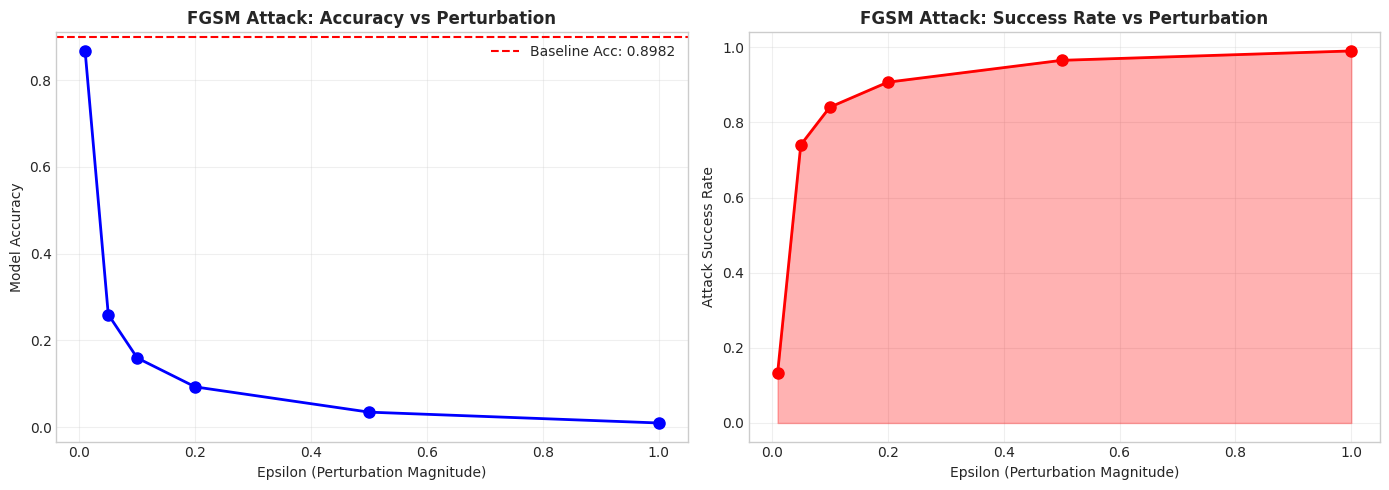

In [33]:
# Visualize FGSM attack effectiveness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Epsilon
ax1 = axes[0]
ax1.plot(fgsm_df['epsilon'], fgsm_df['accuracy'], 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline Acc: {baseline_acc:.4f}')
ax1.set_xlabel('Epsilon (Perturbation Magnitude)')
ax1.set_ylabel('Model Accuracy')
ax1.set_title('FGSM Attack: Accuracy vs Perturbation', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Attack Success Rate vs Epsilon
ax2 = axes[1]
ax2.plot(fgsm_df['epsilon'], fgsm_df['attack_success_rate'], 'ro-', linewidth=2, markersize=8)
ax2.fill_between(fgsm_df['epsilon'], fgsm_df['attack_success_rate'], alpha=0.3, color='red')
ax2.set_xlabel('Epsilon (Perturbation Magnitude)')
ax2.set_ylabel('Attack Success Rate')
ax2.set_title('FGSM Attack: Success Rate vs Perturbation', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fgsm_attack_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [34]:
# Adversarial Defense: Test Random Forest robustness
print("\n" + "=" * 60)
print("ADVERSARIAL ROBUSTNESS COMPARISON")
print("=" * 60)

# Generate adversarial examples using strongest epsilon
best_eps = 0.5
X_adv_strong = fgsm_attack(X_test_sample.values, y_test_sample.values, linear_svm, best_eps)

# Test different models on adversarial examples
models_to_test = [
    ('Linear SVM', linear_svm),
    ('Random Forest', rf_clf),
    ('Gradient Boosting', gb_clf)
]

print(f"\nTesting model robustness against FGSM (epsilon={best_eps}):")
print("-" * 50)

robustness_results = []
for name, model in models_to_test:
    # Original accuracy
    y_pred_orig = model.predict(X_test_sample)
    orig_acc = (y_pred_orig == y_test_sample.values).mean()
    
    # Adversarial accuracy
    y_pred_adv = model.predict(X_adv_strong)
    adv_acc = (y_pred_adv == y_test_sample.values).mean()
    
    # Robustness = how much accuracy is retained
    robustness = adv_acc / orig_acc if orig_acc > 0 else 0
    
    print(f"{name:20} | Original: {orig_acc:.4f} | Adversarial: {adv_acc:.4f} | Robustness: {robustness:.2%}")
    
    robustness_results.append({
        'model': name,
        'original_accuracy': orig_acc,
        'adversarial_accuracy': adv_acc,
        'robustness': robustness
    })

robustness_df = pd.DataFrame(robustness_results)


ADVERSARIAL ROBUSTNESS COMPARISON

Testing model robustness against FGSM (epsilon=0.5):
--------------------------------------------------
Linear SVM           | Original: 0.8982 | Adversarial: 0.0347 | Robustness: 3.86%
Random Forest        | Original: 0.9433 | Adversarial: 0.5673 | Robustness: 60.14%
Gradient Boosting    | Original: 0.9445 | Adversarial: 0.4345 | Robustness: 46.00%


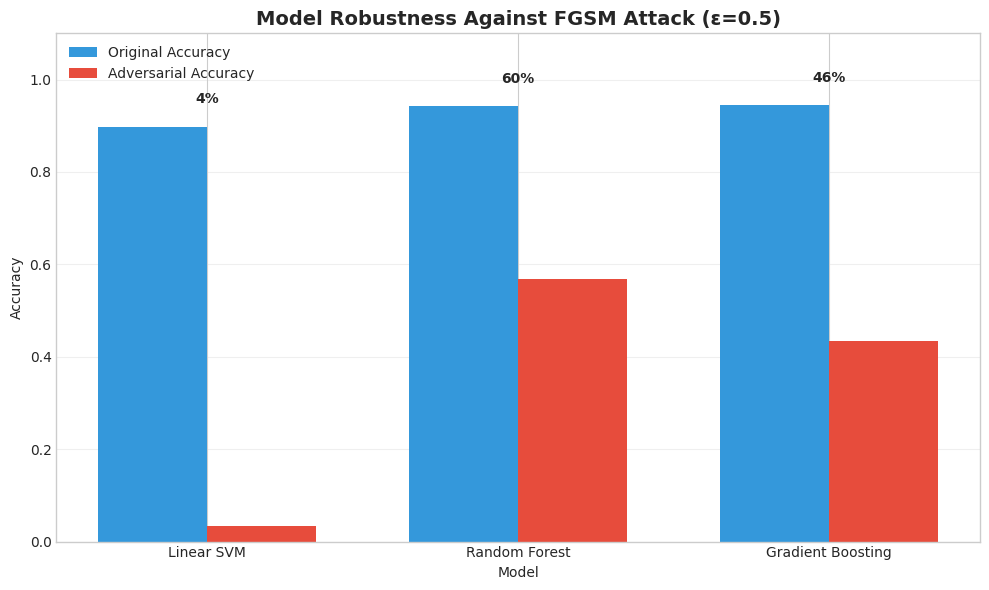

In [35]:
# Visualize model robustness
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(robustness_df))
width = 0.35

bars1 = ax.bar(x - width/2, robustness_df['original_accuracy'], width, 
               label='Original Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, robustness_df['adversarial_accuracy'], width,
               label='Adversarial Accuracy', color='#e74c3c')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title(f'Model Robustness Against FGSM Attack (ε={best_eps})', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(robustness_df['model'])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add robustness percentage labels
for i, (_, row) in enumerate(robustness_df.iterrows()):
    ax.annotate(f'{row["robustness"]:.0%}', 
                xy=(i, max(row['original_accuracy'], row['adversarial_accuracy']) + 0.05),
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Conclusions

In [36]:
print("=" * 60)
print("ANALYSIS CONCLUSIONS")
print("=" * 60)

print("""
1. DATASET CHARACTERISTICS:
   - The CIC-IIoT-2025 dataset contains diverse attack types including DDoS, DoS, 
     MitM, web attacks, reconnaissance, malware, and brute force attacks.
   - Key distinguishing features include TCP flags, packet counts, and timing metrics.
   - Moderate class imbalance exists between benign and attack samples.

2. ANOMALY DETECTION FINDINGS:
""")

best_anomaly = anomaly_results.loc[anomaly_results['f1'].idxmax()]
print(f"   - Best performer: {best_anomaly['model']} (F1={best_anomaly['f1']:.4f})")
print("   - Isolation Forest shows strong performance for detecting novel attack patterns.")
print("   - One-Class SVM provides good boundary learning but is computationally expensive.")
print("   - LOF excels at detecting local density anomalies.")

print("""
3. CLASSIFICATION FINDINGS:
""")

best_classifier = classification_results.loc[classification_results['f1'].idxmax()]
print(f"   - Best performer: {best_classifier['model']}")
print(f"     * F1-Score: {best_classifier['f1']:.4f}")
print(f"     * AUPRC: {best_classifier['auprc']:.4f}")
print(f"     * MCC: {best_classifier['mcc']:.4f}")
print("   - Random Forest provides the best balance of accuracy and interpretability.")
print("   - Gradient Boosting shows competitive performance with sequential learning.")
print("   - All classifiers achieve high recall, crucial for security applications.")

print("""
4. ADVERSARIAL ROBUSTNESS:
""")

most_robust = robustness_df.loc[robustness_df['robustness'].idxmax()]
print(f"   - Most robust model: {most_robust['model']} ({most_robust['robustness']:.1%} robustness)")
print("   - Ensemble methods (Random Forest, Gradient Boosting) show better adversarial robustness.")
print("   - Linear models are more susceptible to gradient-based attacks.")

print("""
5. RECOMMENDATIONS:
   - Deploy ensemble models (Random Forest) for production intrusion detection.
   - Implement adversarial training to improve model robustness.
   - Use anomaly detection as a complementary layer for zero-day attack detection.
   - Consider real-time feature extraction for practical deployment.
   - Regularly retrain models with new attack patterns.
""")

ANALYSIS CONCLUSIONS

1. DATASET CHARACTERISTICS:
   - The CIC-IIoT-2025 dataset contains diverse attack types including DDoS, DoS, 
     MitM, web attacks, reconnaissance, malware, and brute force attacks.
   - Key distinguishing features include TCP flags, packet counts, and timing metrics.
   - Moderate class imbalance exists between benign and attack samples.

2. ANOMALY DETECTION FINDINGS:

   - Best performer: Local Outlier Factor (F1=0.8431)
   - Isolation Forest shows strong performance for detecting novel attack patterns.
   - One-Class SVM provides good boundary learning but is computationally expensive.
   - LOF excels at detecting local density anomalies.

3. CLASSIFICATION FINDINGS:

   - Best performer: Gradient Boosting
     * F1-Score: 0.9245
     * AUPRC: 0.9436
     * MCC: 0.8851
   - Random Forest provides the best balance of accuracy and interpretability.
   - Gradient Boosting shows competitive performance with sequential learning.
   - All classifiers achieve high

In [37]:
# Final Summary Table
print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

print("\n--- ANOMALY DETECTION ---")
print(anomaly_results.to_string(index=False))

print("\n--- CLASSIFICATION ---")
print(classification_results.to_string(index=False))

print("\n--- ADVERSARIAL ROBUSTNESS ---")
print(robustness_df.to_string(index=False))

print("\n" + "=" * 60)
print("Analysis Complete!")
print("=" * 60)


FINAL RESULTS SUMMARY

--- ANOMALY DETECTION ---
               model  precision  recall       f1  balanced_accuracy      mcc
    Isolation Forest   0.882996  0.7758 0.825934             0.8365 0.678015
       One-Class SVM   0.584713  0.8476 0.692031             0.6228 0.274957
Local Outlier Factor   0.886951  0.8034 0.843111             0.8505 0.704131

--- CLASSIFICATION ---
            model  precision   recall       f1  balanced_accuracy      mcc    auprc  auc_roc
    Random Forest   0.991544 0.862658 0.922622           0.928899 0.882527 0.943833 0.958151
Gradient Boosting   0.991140 0.866309 0.924530           0.930596 0.885059 0.943612 0.958721
 SVM (RBF Kernel)   0.962874 0.797026 0.872136           0.888119 0.807442 0.923809 0.932499

--- ADVERSARIAL ROBUSTNESS ---
            model  original_accuracy  adversarial_accuracy  robustness
       Linear SVM             0.8982                0.0347    0.038633
    Random Forest             0.9433                0.5673    0.601399
G